# Fed-BioMed Researcher to train a model on a CSV dataset

In [ ]:
from pathlib import Path

from dotenv import dotenv_values

# settings
ML_PROBLEM_TYPE = "classification"  # "classification", "regression"
SETUP_TYPE = "silo"  # "mega", "silo", "fed"
DATASETS = ["adni", "ppmi", "qpn"]
I_SPLIT = 0
NN_LAYER_SIZE = 1024
FEDBIOMED_ROUNDS = 1

ENV_VARS = dotenv_values("../.env")
RNG_SEED = ENV_VARS["RANDOM_SEED"]
DPATH_DATA = Path(ENV_VARS["DPATH_FL_DATA"])
DPATH_FIGS = Path(ENV_VARS["DPATH_FL_FIGS"])
DPATH_RESULTS = Path(ENV_VARS["DPATH_FL_RESULTS"])
# TODO DPATH_MODELS

FEDBIOMED_TAGS = [f"{I_SPLIT}train"]
if SETUP_TYPE == "mega":
    FEDBIOMED_TAGS.append(SETUP_TYPE)
else:
    FEDBIOMED_TAGS.append(
        "fed"
    )  # for fed or silo (if silo, will add another tag after)

if ML_PROBLEM_TYPE == "classification":
    TARGET_COLS = ["COG_DECLINE"]
    DATA_TAGS = "decline-age-case-aparc"
    FEDBIOMED_TAGS.append("cog_decline")
elif ML_PROBLEM_TYPE == "regression":
    TARGET_COLS = ["AGE"]
    DATA_TAGS = "age-sex-hc-aseg"
    FEDBIOMED_TAGS.append("brain_age")

## Create an experiment to train a model on the data found

Declare a torch training plan MyTrainingPlan class to send for training on the node

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from skrub import TableVectorizer

from fedbiomed.common.training_plans import TorchTrainingPlan, FedSGDClassifier
from fedbiomed.common.data import DataManager


# Here we define the model to be used.
# You can use any class name (here 'MyTrainingPlan')
# class MyTrainingPlan(TorchTrainingPlan):
class MyTrainingPlan(FedSGDClassifier):

    # class Net(nn.Module):

    #     def __init__(self, model_args):

    #         super().__init__()
    #         self.n_features_in = model_args["n_features_in"]
    #         self.n_features_out = model_args["n_features_out"]
    #         self.layer_size = model_args["layer_size"]
    #         self.problem_type = model_args["problem_type"]

    #         # should match the model arguments dict passed below to the experiment class
    #         self.hidden = nn.Linear(self.n_features_in, self.layer_size)
    #         self.relu = nn.ReLU()
    #         self.output = nn.Linear(self.layer_size, self.n_features_out)
    #         if self.problem_type == "classification":
    #             self.activation = nn.Sigmoid()
    #         else:
    #             self.activation = nn.Identity()

    #     def forward(self, x):
    #         x = self.hidden(x)
    #         x = self.relu(x)
    #         x = self.output(x)
    #         x = self.activation(x)
    #         return x

    # def __init__(self, *args, **kwargs):
    #     super().__init__(*args, **kwargs)
    #     self.table_vectorizer_ = None  # for debugging

    def init_dependencies(self):
        # Here we define the custom dependencies that will be needed
        deps = [
            "import numpy as np",
            "import pandas as pd",
            "from skrub import TableVectorizer",
            "from torch.utils.data import Dataset",
        ]

        return deps

    # def init_optimizer(self):
    #     # default is Pytorch Adam optimizer
    #     return super().init_optimizer()

    # def init_model(self, model_args):
    #     model = self.Net(model_args)
    #     return model

    # def training_step(self, data, target):
    #     output = self.model().forward(data).float()
    #     if (problem_type := self.model_args()["problem_type"]) == "classification":
    #         criterion = torch.nn.BCELoss()
    #     elif problem_type == "regression":
    #         criterion = torch.nn.MSELoss()
    #     else:
    #         raise ValueError(f"Unknown problem type: {problem_type}")
    #     loss = criterion(output, target)
    #     return loss

    def training_data(self):
        X_train, y_train, table_vectorizer = self.get_Xy(
            self.dataset_path,
            target_cols=self.model_args()["target_cols"],
            return_vectorizer=True,
        )
        self.table_vectorizer_ = table_vectorizer

        if y_train.shape[1] != self.model_args()["n_features_out"]:
            raise RuntimeError(
                f"Expected {self.model_args()['n_features_out']} output "
                f"features, got {y_train.shape[1]}"
            )
        if X_train.shape[1] != self.model_args()["n_features_in"]:
            raise RuntimeError(
                f"Expected {self.model_args()['n_features_in']} input features"
                f", got {X_train.shape[1]}: {X_train.columns}"
            )

        train_kwargs = {"shuffle": self.model_args()["shuffle"]}

        data_manager = DataManager(
            dataset=X_train.values, target=y_train.values, **train_kwargs
        )

        self.set_model_params({"classes_": np.unique(y_train)})

        return data_manager

    def get_Xy(
        self,
        fpath,
        target_cols,
        return_vectorizer=False,
        dataset=None,
        setup_type=None,
        datasets=None,
    ):
        is_mega = setup_type == "mega"

        df = pd.read_csv(fpath, sep="\t")
        df = df.set_index("participant_id")
        df = df.dropna(axis="index", how="any")

        df = df.query("AGE >= 55")

        table_vectorizer = TableVectorizer()
        df = table_vectorizer.fit_transform(df)

        if is_mega and dataset not in df.columns:
            if datasets is None:
                raise ValueError("datasets is None")
            for col_dataset in datasets:
                if col_dataset not in df.columns:
                    df.loc[:, col_dataset] = 1 if col_dataset == dataset else 0

        y_train = df.loc[:, target_cols]
        X_train = df.drop(columns=target_cols)

        if return_vectorizer:
            return X_train, y_train, table_vectorizer
        else:
            return X_train, y_train

In [145]:
# load test data
Xy_test_all = {}
n_features_in = None
n_features_out = None
for col_dataset in DATASETS:
    fpath = (
        DPATH_DATA
        / f"{col_dataset}-{DATA_TAGS}"
        / f"{col_dataset}-{DATA_TAGS}-{I_SPLIT}test.tsv"
    )
    X_test, y_test = MyTrainingPlan().get_Xy(
        fpath,
        target_cols=TARGET_COLS,
        setup_type=SETUP_TYPE,
        dataset=col_dataset,
        datasets=DATASETS,
    )

    if n_features_in is None:
        n_features_in = X_test.shape[1]
    else:
        assert n_features_in == X_test.shape[1], "Inconsistent number of features"

    if n_features_out is None:
        n_features_out = y_test.shape[1]
    else:
        assert n_features_out == y_test.shape[1], "Inconsistent number of targets"

    Xy_test_all[col_dataset] = (X_test, y_test)

# # but we need the X_test to also have these extra columns
# if SETUP_TYPE == "mega":
#     n_features_in += len(DATASETS)  # extra dataset indicator columns

print(f"Number of input features: {n_features_in}")
print(f"Number of output features: {n_features_out}")

Number of input features: 63
Number of output features: 1


In [146]:
from fedbiomed.common.metrics import MetricTypes
from fedbiomed.researcher.federated_workflows import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

# # model parameters
# model_args = {
#     "n_features_in": n_features_in,
#     "n_features_out": n_features_out,
#     "layer_size": NN_LAYER_SIZE,
#     "target_cols": TARGET_COLS,
#     "shuffle": True,
#     "problem_type": ML_PROBLEM_TYPE,
# }

# # training parameters
# training_args = {
#     "loader_args": {
#         "batch_size": 2000,
#     },
#     "optimizer_args": {"lr": 1e-3},
#     "epochs": 10,
#     "dry_run": False,
# }
model_args = {
    # "class_weight": "balanced",
    "random_state": RNG_SEED,
    "n_features": n_features_in,
    "n_classes": 2,
    "n_features_in": n_features_in,
    "n_features_out": n_features_out,
    "target_cols": TARGET_COLS,
    "shuffle": True,
    "problem_type": ML_PROBLEM_TYPE,
}

training_args = {
    "epochs": 100,
    "loader_args": {
        "batch_size": 128,
    },
}

# Calling the training data with specified tags
exp = Experiment(
    tags=FEDBIOMED_TAGS + ["adni"],
    training_plan_class=MyTrainingPlan,
    model_args=model_args,
    training_args=training_args,
    round_limit=FEDBIOMED_ROUNDS,
    aggregator=FedAverage(),
    node_selection_strategy=None,
)

2025-04-14 18:32:12,468 fedbiomed INFO - Updating training data. This action will update FederatedDataset, and the nodes that will participate to the experiment.

2025-04-14 18:32:12,477 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-14 18:32:12,480 fedbiomed INFO - Node selected for training -> NODE_ab268c68-f166-45b7-a73a-8cb390df85fe

<function extract_symbols at 0x7f0b45942dd0>


2025-04-14 18:32:12,515 fedbiomed DEBUG - Model file has been saved: /data/origami/michelle/projects/fl-pd/federation/fbm-researcher/var/experiments/Experiment_0061/model_6f7e9d63-585f-460a-98c0-dc50c9ad2362.py

2025-04-14 18:32:12,568 fedbiomed WARNING - Option share_persistent_buffers is not supported in SKLearnTrainingPlan, it will be ignored.

2025-04-14 18:32:12,570 fedbiomed DEBUG - Using native Sklearn Optimizer

In [147]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import SGDClassifier

X_train, y_train = MyTrainingPlan().get_Xy(
    DPATH_DATA / f"adni-{DATA_TAGS}" / f"adni-{DATA_TAGS}-{I_SPLIT}train.tsv",
    target_cols=TARGET_COLS,
)
X_test, y_test = Xy_test_all["adni"]

model = SGDClassifier()
model.fit(X_train, y_train.values.ravel())

print(
    f"Balanced accuracy (train): {balanced_accuracy_score(y_train, model.predict(X_train))}"
)
print(
    f"Balanced accuracy (test): {balanced_accuracy_score(y_test, model.predict(X_test))}"
)

Balanced accuracy (train): 0.5978701724902242
Balanced accuracy (test): 0.5902255639097744


Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the nodes

In [148]:
exp.run()

2025-04-14 18:32:17,868 fedbiomed INFO - Sampled nodes in round 0 ['NODE_ab268c68-f166-45b7-a73a-8cb390df85fe']

<function extract_symbols at 0x7f0b45942dd0>


2025-04-14 18:32:17,872 fedbiomed INFO - Sending request 
					 To: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-04-14 18:32:17,944 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-14 18:32:18,239 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 1 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 1.000000 
					 ---------

2025-04-14 18:32:18,492 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 1 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 5624.307617 
					 ---------

2025-04-14 18:32:18,540 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 2 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 4209.066895 
					 ---------

2025-04-14 18:32:18,641 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 2 | Iteration: 3/7 (43%) | Samples: 384/896
 					 Loss hinge: 4862.770020 
					 ---------

2025-04-14 18:32:18,790 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 2 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 4501.998535 
					 ---------

2025-04-14 18:32:18,841 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 3 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 395.797333 
					 ---------

2025-04-14 18:32:19,086 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 3 | Iteration: 6/7 (86%) | Samples: 768/896
 					 Loss hinge: 581.017029 
					 ---------

2025-04-14 18:32:19,090 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 3 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 2318.128662 
					 ---------

2025-04-14 18:32:19,141 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 4 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 2184.822021 
					 ---------

2025-04-14 18:32:19,390 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 4 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 118.534798 
					 ---------

2025-04-14 18:32:19,440 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 5 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 2695.350830 
					 ---------

2025-04-14 18:32:19,492 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 5 | Iteration: 2/7 (29%) | Samples: 256/896
 					 Loss hinge: 581.063538 
					 ---------

2025-04-14 18:32:19,691 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 5 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 1232.090942 
					 ---------

2025-04-14 18:32:19,744 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 6 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 1687.349854 
					 ---------

2025-04-14 18:32:19,938 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 6 | Iteration: 5/7 (71%) | Samples: 640/896
 					 Loss hinge: 2142.531006 
					 ---------

2025-04-14 18:32:19,993 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 6 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 1900.464355 
					 ---------

2025-04-14 18:32:20,044 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 7 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 279.357452 
					 ---------

2025-04-14 18:32:20,295 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 7 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 1171.416992 
					 ---------

2025-04-14 18:32:20,346 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 8 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 1018.899414 
					 ---------

2025-04-14 18:32:20,595 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 8 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 17.523355 
					 ---------

2025-04-14 18:32:20,643 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 9 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 71.861443 
					 ---------

2025-04-14 18:32:20,791 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 9 | Iteration: 4/7 (57%) | Samples: 512/896
 					 Loss hinge: 1647.794800 
					 ---------

2025-04-14 18:32:20,895 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 9 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 688.343262 
					 ---------

2025-04-14 18:32:20,945 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 10 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 172.816208 
					 ---------

2025-04-14 18:32:21,202 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 10 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 677.137756 
					 ---------

2025-04-14 18:32:21,253 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 11 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 1491.542236 
					 ---------

2025-04-14 18:32:21,501 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 11 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 501.847595 
					 ---------

2025-04-14 18:32:21,553 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 12 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 539.275818 
					 ---------

2025-04-14 18:32:21,652 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 12 | Iteration: 3/7 (43%) | Samples: 384/896
 					 Loss hinge: 852.690186 
					 ---------

2025-04-14 18:32:21,803 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 12 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 83.959244 
					 ---------

2025-04-14 18:32:21,853 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 13 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 1209.158691 
					 ---------

2025-04-14 18:32:22,100 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 13 | Iteration: 6/7 (86%) | Samples: 768/896
 					 Loss hinge: 742.827881 
					 ---------

2025-04-14 18:32:22,103 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 13 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 350.273804 
					 ---------

2025-04-14 18:32:22,155 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 14 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 1246.504761 
					 ---------

2025-04-14 18:32:22,405 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 14 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 723.095642 
					 ---------

2025-04-14 18:32:22,454 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 15 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 779.482239 
					 ---------

2025-04-14 18:32:22,508 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 15 | Iteration: 2/7 (29%) | Samples: 256/896
 					 Loss hinge: 602.866516 
					 ---------

2025-04-14 18:32:22,705 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 15 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 838.954773 
					 ---------

2025-04-14 18:32:22,758 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 16 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 379.096375 
					 ---------

2025-04-14 18:32:22,954 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 16 | Iteration: 5/7 (71%) | Samples: 640/896
 					 Loss hinge: 221.328506 
					 ---------

2025-04-14 18:32:23,011 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 16 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 49.210133 
					 ---------

2025-04-14 18:32:23,067 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 17 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 332.375305 
					 ---------

2025-04-14 18:32:23,329 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 17 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 41.763351 
					 ---------

2025-04-14 18:32:23,384 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 18 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 490.728790 
					 ---------

2025-04-14 18:32:23,648 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 18 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 366.357910 
					 ---------

2025-04-14 18:32:23,759 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 19 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 587.158569 
					 ---------

2025-04-14 18:32:23,870 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 19 | Iteration: 4/7 (57%) | Samples: 512/896
 					 Loss hinge: 472.492828 
					 ---------

2025-04-14 18:32:23,986 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 19 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 52.312031 
					 ---------

2025-04-14 18:32:24,042 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 20 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 263.476440 
					 ---------

2025-04-14 18:32:24,308 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 20 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 562.356140 
					 ---------

2025-04-14 18:32:24,419 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 21 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 70.015282 
					 ---------

2025-04-14 18:32:24,633 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 21 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 73.698441 
					 ---------

2025-04-14 18:32:24,745 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 22 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 805.788696 
					 ---------

2025-04-14 18:32:24,801 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 22 | Iteration: 3/7 (43%) | Samples: 384/896
 					 Loss hinge: 447.324890 
					 ---------

2025-04-14 18:32:24,965 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 22 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 394.894775 
					 ---------

2025-04-14 18:32:25,021 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 23 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 701.151855 
					 ---------

2025-04-14 18:32:25,283 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 23 | Iteration: 6/7 (86%) | Samples: 768/896
 					 Loss hinge: 318.399323 
					 ---------

2025-04-14 18:32:25,289 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 23 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 230.886780 
					 ---------

2025-04-14 18:32:25,400 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 24 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 328.905762 
					 ---------

2025-04-14 18:32:25,624 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 24 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 143.418076 
					 ---------

2025-04-14 18:32:25,677 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 25 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 248.593353 
					 ---------

2025-04-14 18:32:25,726 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 25 | Iteration: 2/7 (29%) | Samples: 256/896
 					 Loss hinge: 519.742493 
					 ---------

2025-04-14 18:32:25,940 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 25 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 494.204498 
					 ---------

2025-04-14 18:32:25,999 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 26 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 284.202393 
					 ---------

2025-04-14 18:32:26,218 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 26 | Iteration: 5/7 (71%) | Samples: 640/896
 					 Loss hinge: 426.060028 
					 ---------

2025-04-14 18:32:26,267 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 26 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 341.065430 
					 ---------

2025-04-14 18:32:26,324 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 27 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 50.490993 
					 ---------

2025-04-14 18:32:26,587 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 27 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 228.670486 
					 ---------

2025-04-14 18:32:26,698 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 28 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 771.631958 
					 ---------

2025-04-14 18:32:26,970 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 28 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 167.193268 
					 ---------

2025-04-14 18:32:27,026 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 29 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 483.758942 
					 ---------

2025-04-14 18:32:27,188 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 29 | Iteration: 4/7 (57%) | Samples: 512/896
 					 Loss hinge: 273.725342 
					 ---------

2025-04-14 18:32:27,254 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 29 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 231.362030 
					 ---------

2025-04-14 18:32:27,365 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 30 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 552.654846 
					 ---------

2025-04-14 18:32:27,579 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 30 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 192.094437 
					 ---------

2025-04-14 18:32:27,690 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 31 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 107.188934 
					 ---------

2025-04-14 18:32:27,912 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 31 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 364.702820 
					 ---------

2025-04-14 18:32:27,967 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 32 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 253.208359 
					 ---------

2025-04-14 18:32:28,132 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 32 | Iteration: 3/7 (43%) | Samples: 384/896
 					 Loss hinge: 133.074051 
					 ---------

2025-04-14 18:32:28,248 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 32 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 78.647720 
					 ---------

2025-04-14 18:32:28,346 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 33 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 345.814819 
					 ---------

2025-04-14 18:32:28,555 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 33 | Iteration: 6/7 (86%) | Samples: 768/896
 					 Loss hinge: 122.143799 
					 ---------

2025-04-14 18:32:28,614 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 33 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 325.363007 
					 ---------

2025-04-14 18:32:28,725 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 34 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 61.322639 
					 ---------

2025-04-14 18:32:28,891 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 34 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 89.320152 
					 ---------

2025-04-14 18:32:28,947 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 35 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 195.751373 
					 ---------

2025-04-14 18:32:29,003 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 35 | Iteration: 2/7 (29%) | Samples: 256/896
 					 Loss hinge: 245.594528 
					 ---------

2025-04-14 18:32:29,227 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 35 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 322.452576 
					 ---------

2025-04-14 18:32:29,283 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 36 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 316.580719 
					 ---------

2025-04-14 18:32:29,495 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 36 | Iteration: 5/7 (71%) | Samples: 640/896
 					 Loss hinge: 111.032997 
					 ---------

2025-04-14 18:32:29,556 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 36 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 46.401981 
					 ---------

2025-04-14 18:32:29,667 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 37 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 100.232849 
					 ---------

2025-04-14 18:32:29,874 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 37 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 387.339508 
					 ---------

2025-04-14 18:32:29,930 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 38 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 83.408752 
					 ---------

2025-04-14 18:32:30,191 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 38 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 154.835815 
					 ---------

2025-04-14 18:32:30,303 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 39 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 313.836823 
					 ---------

2025-04-14 18:32:30,414 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 39 | Iteration: 4/7 (57%) | Samples: 512/896
 					 Loss hinge: 279.686554 
					 ---------

2025-04-14 18:32:30,530 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 39 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 39.749866 
					 ---------

2025-04-14 18:32:30,585 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 40 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 133.865280 
					 ---------

2025-04-14 18:32:30,856 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 40 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 116.564621 
					 ---------

2025-04-14 18:32:30,967 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 41 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 507.204742 
					 ---------

2025-04-14 18:32:31,180 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 41 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 258.262085 
					 ---------

2025-04-14 18:32:31,236 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 42 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 54.567204 
					 ---------

2025-04-14 18:32:31,348 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 42 | Iteration: 3/7 (43%) | Samples: 384/896
 					 Loss hinge: 201.166214 
					 ---------

2025-04-14 18:32:31,514 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 42 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 123.944580 
					 ---------

2025-04-14 18:32:31,569 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 43 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 115.271774 
					 ---------

2025-04-14 18:32:31,826 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 43 | Iteration: 6/7 (86%) | Samples: 768/896
 					 Loss hinge: 77.987144 
					 ---------

2025-04-14 18:32:31,887 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 43 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 49.238022 
					 ---------

2025-04-14 18:32:32,053 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 44 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 44.990288 
					 ---------

2025-04-14 18:32:32,169 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 44 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 224.444153 
					 ---------

2025-04-14 18:32:32,226 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 45 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 232.832214 
					 ---------

2025-04-14 18:32:32,284 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 45 | Iteration: 2/7 (29%) | Samples: 256/896
 					 Loss hinge: 176.610611 
					 ---------

2025-04-14 18:32:32,501 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 45 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 153.988541 
					 ---------

2025-04-14 18:32:32,557 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 46 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 302.973907 
					 ---------

2025-04-14 18:32:32,827 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 46 | Iteration: 5/7 (71%) | Samples: 640/896
 					 Loss hinge: 184.134827 
					 ---------

2025-04-14 18:32:32,883 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 46 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 212.073273 
					 ---------

2025-04-14 18:32:33,049 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 47 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 243.269897 
					 ---------

2025-04-14 18:32:33,165 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 47 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 108.031616 
					 ---------

2025-04-14 18:32:33,221 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 48 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 258.946533 
					 ---------

2025-04-14 18:32:33,473 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 48 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 201.873947 
					 ---------

2025-04-14 18:32:33,525 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 49 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 81.402672 
					 ---------

2025-04-14 18:32:33,673 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 49 | Iteration: 4/7 (57%) | Samples: 512/896
 					 Loss hinge: 161.823120 
					 ---------

2025-04-14 18:32:33,774 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 49 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 56.005772 
					 ---------

2025-04-14 18:32:33,825 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 50 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 89.599586 
					 ---------

2025-04-14 18:32:34,073 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 50 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 206.893341 
					 ---------

2025-04-14 18:32:34,125 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 51 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 121.572411 
					 ---------

2025-04-14 18:32:34,374 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 51 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 139.110962 
					 ---------

2025-04-14 18:32:34,426 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 52 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 208.446335 
					 ---------

2025-04-14 18:32:34,528 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 52 | Iteration: 3/7 (43%) | Samples: 384/896
 					 Loss hinge: 130.177948 
					 ---------

2025-04-14 18:32:34,674 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 52 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 88.121368 
					 ---------

2025-04-14 18:32:34,783 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 53 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 151.623993 
					 ---------

2025-04-14 18:32:34,996 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 53 | Iteration: 6/7 (86%) | Samples: 768/896
 					 Loss hinge: 142.688431 
					 ---------

2025-04-14 18:32:35,052 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 53 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 223.889252 
					 ---------

2025-04-14 18:32:35,201 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 54 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 306.987640 
					 ---------

2025-04-14 18:32:35,324 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 54 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 115.285461 
					 ---------

2025-04-14 18:32:35,377 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 55 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 117.529915 
					 ---------

2025-04-14 18:32:35,426 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 55 | Iteration: 2/7 (29%) | Samples: 256/896
 					 Loss hinge: 144.682480 
					 ---------

2025-04-14 18:32:35,626 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 55 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 119.866447 
					 ---------

2025-04-14 18:32:35,677 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 56 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 131.043808 
					 ---------

2025-04-14 18:32:35,877 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 56 | Iteration: 5/7 (71%) | Samples: 640/896
 					 Loss hinge: 45.557755 
					 ---------

2025-04-14 18:32:35,931 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 56 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 23.272715 
					 ---------

2025-04-14 18:32:35,983 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 57 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 41.185558 
					 ---------

2025-04-14 18:32:36,231 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 57 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 133.252228 
					 ---------

2025-04-14 18:32:36,284 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 58 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 128.362747 
					 ---------

2025-04-14 18:32:36,536 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 58 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 114.716606 
					 ---------

2025-04-14 18:32:36,589 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 59 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 340.477539 
					 ---------

2025-04-14 18:32:36,787 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 59 | Iteration: 4/7 (57%) | Samples: 512/896
 					 Loss hinge: 78.381531 
					 ---------

2025-04-14 18:32:36,844 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 59 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 160.886765 
					 ---------

2025-04-14 18:32:36,896 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 60 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 211.265274 
					 ---------

2025-04-14 18:32:37,144 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 60 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 143.409363 
					 ---------

2025-04-14 18:32:37,196 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 61 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 181.630020 
					 ---------

2025-04-14 18:32:37,447 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 61 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 100.863091 
					 ---------

2025-04-14 18:32:37,501 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 62 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 82.842033 
					 ---------

2025-04-14 18:32:37,599 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 62 | Iteration: 3/7 (43%) | Samples: 384/896
 					 Loss hinge: 78.982620 
					 ---------

2025-04-14 18:32:37,754 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 62 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 89.494148 
					 ---------

2025-04-14 18:32:37,804 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 63 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 53.304619 
					 ---------

2025-04-14 18:32:38,052 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 63 | Iteration: 6/7 (86%) | Samples: 768/896
 					 Loss hinge: 69.024437 
					 ---------

2025-04-14 18:32:38,058 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 63 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 94.803528 
					 ---------

2025-04-14 18:32:38,107 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 64 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 87.774155 
					 ---------

2025-04-14 18:32:38,356 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 64 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 122.898476 
					 ---------

2025-04-14 18:32:38,410 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 65 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 69.179016 
					 ---------

2025-04-14 18:32:38,461 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 65 | Iteration: 2/7 (29%) | Samples: 256/896
 					 Loss hinge: 72.526909 
					 ---------

2025-04-14 18:32:38,658 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 65 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 46.545521 
					 ---------

2025-04-14 18:32:38,711 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 66 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 45.592773 
					 ---------

2025-04-14 18:32:38,907 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 66 | Iteration: 5/7 (71%) | Samples: 640/896
 					 Loss hinge: 42.443604 
					 ---------

2025-04-14 18:32:38,960 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 66 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 45.783657 
					 ---------

2025-04-14 18:32:39,012 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 67 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 41.457687 
					 ---------

2025-04-14 18:32:39,261 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 67 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 112.019798 
					 ---------

2025-04-14 18:32:39,313 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 68 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 104.069901 
					 ---------

2025-04-14 18:32:39,562 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 68 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 67.410843 
					 ---------

2025-04-14 18:32:39,614 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 69 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 62.206039 
					 ---------

2025-04-14 18:32:39,762 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 69 | Iteration: 4/7 (57%) | Samples: 512/896
 					 Loss hinge: 122.980270 
					 ---------

2025-04-14 18:32:39,867 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 69 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 73.329407 
					 ---------

2025-04-14 18:32:39,915 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 70 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 181.515991 
					 ---------

2025-04-14 18:32:40,171 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 70 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 91.817238 
					 ---------

2025-04-14 18:32:40,220 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 71 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 89.558685 
					 ---------

2025-04-14 18:32:40,469 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 71 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 112.748543 
					 ---------

2025-04-14 18:32:40,522 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 72 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 166.880478 
					 ---------

2025-04-14 18:32:40,620 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 72 | Iteration: 3/7 (43%) | Samples: 384/896
 					 Loss hinge: 64.588844 
					 ---------

2025-04-14 18:32:40,772 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 72 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 93.366783 
					 ---------

2025-04-14 18:32:40,823 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 73 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 83.376488 
					 ---------

2025-04-14 18:32:41,073 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 73 | Iteration: 6/7 (86%) | Samples: 768/896
 					 Loss hinge: 98.982857 
					 ---------

2025-04-14 18:32:41,080 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 73 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 92.599648 
					 ---------

2025-04-14 18:32:41,127 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 74 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 91.779388 
					 ---------

2025-04-14 18:32:41,377 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 74 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 54.017708 
					 ---------

2025-04-14 18:32:41,429 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 75 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 68.406052 
					 ---------

2025-04-14 18:32:41,480 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 75 | Iteration: 2/7 (29%) | Samples: 256/896
 					 Loss hinge: 56.320591 
					 ---------

2025-04-14 18:32:41,679 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 75 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 77.346664 
					 ---------

2025-04-14 18:32:41,730 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 76 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 106.120293 
					 ---------

2025-04-14 18:32:41,929 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 76 | Iteration: 5/7 (71%) | Samples: 640/896
 					 Loss hinge: 49.932304 
					 ---------

2025-04-14 18:32:41,981 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 76 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 53.181656 
					 ---------

2025-04-14 18:32:42,043 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 77 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 110.457817 
					 ---------

2025-04-14 18:32:42,343 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 77 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 66.338936 
					 ---------

2025-04-14 18:32:42,499 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 78 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 100.752220 
					 ---------

2025-04-14 18:32:42,607 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 78 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 35.187847 
					 ---------

2025-04-14 18:32:42,763 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 79 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 61.589203 
					 ---------

2025-04-14 18:32:42,901 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 79 | Iteration: 4/7 (57%) | Samples: 512/896
 					 Loss hinge: 77.892258 
					 ---------

2025-04-14 18:32:42,924 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 79 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 103.413277 
					 ---------

2025-04-14 18:32:42,977 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 80 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 56.918293 
					 ---------

2025-04-14 18:32:43,227 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 80 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 91.820396 
					 ---------

2025-04-14 18:32:43,278 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 81 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 47.979202 
					 ---------

2025-04-14 18:32:43,527 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 81 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 86.693932 
					 ---------

2025-04-14 18:32:43,579 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 82 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 44.711090 
					 ---------

2025-04-14 18:32:43,681 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 82 | Iteration: 3/7 (43%) | Samples: 384/896
 					 Loss hinge: 46.198128 
					 ---------

2025-04-14 18:32:43,830 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 82 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 89.552956 
					 ---------

2025-04-14 18:32:43,881 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 83 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 182.459290 
					 ---------

2025-04-14 18:32:44,130 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 83 | Iteration: 6/7 (86%) | Samples: 768/896
 					 Loss hinge: 57.644543 
					 ---------

2025-04-14 18:32:44,134 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 83 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 33.740025 
					 ---------

2025-04-14 18:32:44,183 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 84 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 37.326637 
					 ---------

2025-04-14 18:32:44,434 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 84 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 45.081966 
					 ---------

2025-04-14 18:32:44,487 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 85 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 42.391251 
					 ---------

2025-04-14 18:32:44,536 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 85 | Iteration: 2/7 (29%) | Samples: 256/896
 					 Loss hinge: 42.125839 
					 ---------

2025-04-14 18:32:44,735 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 85 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 36.261513 
					 ---------

2025-04-14 18:32:44,786 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 86 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 43.226646 
					 ---------

2025-04-14 18:32:44,983 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 86 | Iteration: 5/7 (71%) | Samples: 640/896
 					 Loss hinge: 56.182991 
					 ---------

2025-04-14 18:32:45,036 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 86 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 42.307186 
					 ---------

2025-04-14 18:32:45,087 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 87 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 43.631550 
					 ---------

2025-04-14 18:32:45,338 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 87 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 35.334133 
					 ---------

2025-04-14 18:32:45,390 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 88 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 102.240173 
					 ---------

2025-04-14 18:32:45,638 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 88 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 65.659706 
					 ---------

2025-04-14 18:32:45,693 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 89 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 64.688255 
					 ---------

2025-04-14 18:32:45,838 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 89 | Iteration: 4/7 (57%) | Samples: 512/896
 					 Loss hinge: 43.431232 
					 ---------

2025-04-14 18:32:45,940 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 89 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 57.413418 
					 ---------

2025-04-14 18:32:45,991 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 90 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 49.810780 
					 ---------

2025-04-14 18:32:46,241 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 90 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 50.448414 
					 ---------

2025-04-14 18:32:46,291 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 91 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 160.206589 
					 ---------

2025-04-14 18:32:46,550 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 91 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 45.432926 
					 ---------

2025-04-14 18:32:46,602 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 92 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 43.466129 
					 ---------

2025-04-14 18:32:46,705 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 92 | Iteration: 3/7 (43%) | Samples: 384/896
 					 Loss hinge: 40.719440 
					 ---------

2025-04-14 18:32:46,853 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 92 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 8.834846 
					 ---------

2025-04-14 18:32:46,904 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 93 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 80.974541 
					 ---------

2025-04-14 18:32:47,150 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 93 | Iteration: 6/7 (86%) | Samples: 768/896
 					 Loss hinge: 31.696163 
					 ---------

2025-04-14 18:32:47,154 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 93 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 54.848194 
					 ---------

2025-04-14 18:32:47,206 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 94 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 110.485809 
					 ---------

2025-04-14 18:32:47,458 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 94 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 67.208946 
					 ---------

2025-04-14 18:32:47,510 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 95 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 42.408543 
					 ---------

2025-04-14 18:32:47,561 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 95 | Iteration: 2/7 (29%) | Samples: 256/896
 					 Loss hinge: 37.460674 
					 ---------

2025-04-14 18:32:47,759 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 95 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 99.106117 
					 ---------

2025-04-14 18:32:47,814 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 96 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 127.796936 
					 ---------

2025-04-14 18:32:48,007 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 96 | Iteration: 5/7 (71%) | Samples: 640/896
 					 Loss hinge: 45.721291 
					 ---------

2025-04-14 18:32:48,061 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 96 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 68.174385 
					 ---------

2025-04-14 18:32:48,112 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 97 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 75.512657 
					 ---------

2025-04-14 18:32:48,366 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 97 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 75.050980 
					 ---------

2025-04-14 18:32:48,415 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 98 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 34.126892 
					 ---------

2025-04-14 18:32:48,693 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 98 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 36.327755 
					 ---------

2025-04-14 18:32:48,728 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 99 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 76.333549 
					 ---------

2025-04-14 18:32:48,867 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 99 | Iteration: 4/7 (57%) | Samples: 512/896
 					 Loss hinge: 35.408638 
					 ---------

2025-04-14 18:32:48,969 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 99 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 56.324799 
					 ---------

2025-04-14 18:32:49,024 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 100 | Iteration: 1/7 (14%) | Samples: 128/896
 					 Loss hinge: 34.441792 
					 ---------

2025-04-14 18:32:49,271 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe 
					 Round 1 Epoch: 100 | Iteration: 7/7 (100%) | Samples: 780/780
 					 Loss hinge: 77.197456 
					 ---------

2025-04-14 18:32:49,330 fedbiomed INFO - Nodes that successfully reply in round 0 ['NODE_ab268c68-f166-45b7-a73a-8cb390df85fe']

1

In [149]:
exp.training_plan().set_model_params(
    exp.aggregated_params()[FEDBIOMED_ROUNDS - 1]["params"]
)
fed_model = exp.training_plan().model()

In [118]:
pd.Series(fed_model.predict(X_train.values)).value_counts()

1    780
Name: count, dtype: int64

In [127]:
type(fed_model)

sklearn.linear_model._stochastic_gradient.SGDClassifier

In [150]:
# test = fed_model.fit(X_train.values, y_train.values.ravel())

print(
    f"Train balanced accuracy: {balanced_accuracy_score(y_train, fed_model.predict(X_train.values))}"
)
print(
    f"Test balanced accuracy: {balanced_accuracy_score(y_test, fed_model.predict(X_test.values))}"
)

Train balanced accuracy: 0.6090320830493784
Test balanced accuracy: 0.6133190118152524


2025-04-14 19:21:47,895 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-14 20:18:21,352 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-14 21:18:21,349 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-14 21:21:00,880 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-14 22:21:00,881 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-14 22:27:09,328 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-14 23:24:57,425 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 00:24:57,427 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 00:30:33,840 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 01:30:33,933 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 02:28:47,149 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 03:28:47,148 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 03:29:47,528 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 04:27:08,302 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 05:27:08,301 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 05:29:21,290 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 06:28:30,491 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 07:28:30,458 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 07:32:48,459 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 08:32:48,459 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

2025-04-15 08:33:51,791 fedbiomed DEBUG - Node: NODE_ab268c68-f166-45b7-a73a-8cb390df85fe polling for the tasks

## TODO after

- Test on each individual dataset's test set
- Also get train performance?
- Get loss from each round?

Save trained model to file

In [ ]:
# exp.training_plan().export_model("./trained_model")

In [ ]:
# print("\nList the training rounds : ", exp.training_replies().keys())

# print("\nList the nodes for the last training round and their timings : ")
# round_data = exp.training_replies()[FEDBIOMED_ROUNDS - 1]
# for r in round_data.values():
#     print(
#         "\t- {id} :\
#     \n\t\trtime_training={rtraining:.2f} seconds\
#     \n\t\tptime_training={ptraining:.2f} seconds\
#     \n\t\trtime_total={rtotal:.2f} seconds".format(
#             id=r["node_id"],
#             rtraining=r["timing"]["rtime_training"],
#             ptraining=r["timing"]["ptime_training"],
#             rtotal=r["timing"]["rtime_total"],
#         )
#     )
# print("\n")

In [ ]:
# round_data["NODE_MEGA"]

In [ ]:
# print("\nList the training rounds : ", exp.aggregated_params().keys())
# print("\nAccess the federated params for the last training round :")
# print(
#     "\t- parameter data: ",
#     exp.aggregated_params()[FEDBIOMED_ROUNDS - 1]["params"].keys(),
# )
# print(exp.aggregated_params()[FEDBIOMED_ROUNDS - 2]["params"]["fc1.weight"].shape)
# print(exp.aggregated_params()[FEDBIOMED_ROUNDS - 2]["params"]["fc1.weight"])

In [ ]:
if ML_PROBLEM_TYPE == "classification":
    fpath_train = (
        DPATH_DATA
        / "mega_adni_ppmi_qpn-decline-age-case-aparc"
        / "mega_adni_ppmi_qpn-decline-age-case-aparc-0train.tsv"
    )
else:
    fpath_train = (
        DPATH_DATA
        / "mega_adni_ppmi_qpn-age-sex-hc-aseg"
        / "mega_adni_ppmi_qpn-age-sex-hc-aseg-0train.tsv"
    )
X_train, y_train = MyTrainingPlan().get_Xy(
    fpath=fpath_train,
    target_cols=TARGET_COLS,
)

In [ ]:
model = MyTrainingPlan().init_model(model_args)
model

Net(
  (hidden): Linear(in_features=66, out_features=1024, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [72]:
model.train()
model(torch.tensor(X_train.values).float())
model.eval()

Net(
  (hidden): Linear(in_features=66, out_features=1024, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
model(torch.tensor(X_train.values).float())

In [ ]:
exp.training_plan().set_model_params(
    exp.aggregated_params()[FEDBIOMED_ROUNDS - 1]["params"]
)
fed_model = exp.training_plan().model()
fed_model.eval()
# fed_model.hidden.weight

In [ ]:
import torch

# y_pred = fed_model(torch.tensor(Xy_test_all["ppmi"][0].to_numpy(dtype="float32")))
logits = fed_model(torch.tensor(X_train.to_numpy(dtype="float32"))).detach().numpy()
y_train_pred = logits.round()

<Axes: >

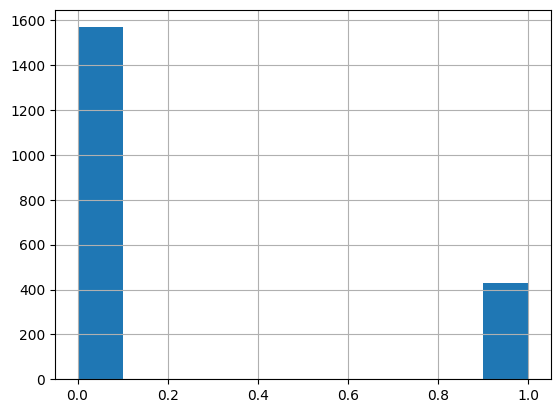

In [ ]:
pd.Series(y_train_pred.squeeze()).hist()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_train, y_train_pred)

0.6161021931743601